In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.metrics import roc_auc_score
from geopy.distance import vincenty
sns.set_style("darkgrid")

In [2]:
%%javascript
$('.nbp-app-bar').toggle()

<IPython.core.display.Javascript object>

# Read and Split the Data

In [3]:
weather=pd.read_csv('weather2.csv')
readings=pd.read_csv('readings.csv')

In [4]:
chicago=pd.merge(readings, weather, on='Date').drop(['Date', 'Month', 'Year', 'CULEX'], axis=1);
print(chicago.shape)
chicago.head()

(10506, 12)


,Virus,DayRunner,ALTER,PIPIENS,PIPIENS-RESTUANS,RESTUANS,near_hotspot,near_chompspot,avg_rain1,avg_rain2,avg_dry1,avg_dry2
0,0,149,0,0,1,0,1,4,0.714286,0.428571,0.857143,0.571429
1,0,149,0,0,0,1,1,4,0.714286,0.428571,0.857143,0.571429
2,0,149,0,0,0,1,0,3,0.714286,0.428571,0.857143,0.571429
3,0,149,0,0,1,0,2,4,0.714286,0.428571,0.857143,0.571429
4,0,149,0,0,0,1,2,4,0.714286,0.428571,0.857143,0.571429


In [5]:
# Split the data
X = chicago.drop(['Virus'], axis=1)
y = chicago['Virus']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=42)
X_train.shape # Notice the number of rows in the training set. This should stay constant.

(8404, 11)

In [6]:
# List the features
X.columns

Index(['DayRunner', 'ALTER', 'PIPIENS', 'PIPIENS-RESTUANS', 'RESTUANS',
       'near_hotspot', 'near_chompspot', 'avg_rain1', 'avg_rain2', 'avg_dry1',
       'avg_dry2'],
      dtype='object')

# Model 1. KNN classifier 

#### fit on the training, predict on the testing data

In [7]:
# train the model
neighs = KNeighborsClassifier(n_neighbors=7)
knn_model = neighs.fit(X_train, y_train)

In [8]:
# The crossvalidiation score scores our performance on the training data. 
scores = cross_val_score(knn_model, X_train, y_train, cv=5)
np.mean(scores), np.std(scores) # This is the mean of the 5 cv scores, plus its standard dev.

(0.9439549088809569, 0.0046952383870515566)

In [9]:
# Predict the y values on the testing data.
y_hat = knn_model.predict(X_test)

#### Score my model

In [10]:
# Set up some empty lists, so we can compare our models at the end
acc=[]
sens=[]
spec=[]
roc=[]

In [11]:
# There are two different ways to get the accuracy score, which is our primary metric:
modscore=100*(knn_model.score(X_test, y_test))
accuracy=100*metrics.accuracy_score(y_test, y_hat)
acc.append(accuracy)
print(modscore)
print(accuracy)

94.6241674596
94.6241674596


In [12]:
# A confusion matrix tells us our false positives and false negatives:
mat = confusion_matrix(y_test, y_hat)
print (mat)

[[1985    7]
 [ 106    4]]


In [13]:
# Let's interpret that.
tn, fp, fn, tp = mat.ravel()
sensitivity = 100*tp/(tp+fn)
specificity=100*tn/(tn+fp)
sens.append(sensitivity)
spec.append(specificity)

print('sensitivity:', sensitivity)
print('specificity:', specificity)

sensitivity: 3.63636363636
specificity: 99.6485943775


In [14]:
# Our ROC-AUC score measures the trade-off between specificity and sensitivity
roc_score=100*roc_auc_score(y_test, y_hat)
roc.append(roc_score)
print(roc_score)

51.6424790069


# Model 2. Logistic Classifier

#### fit on the training, predict on the testing data

In [15]:
# train the model
logit = LogisticRegression()
log_model=logit.fit(X_train, y_train)

In [16]:
# The crossvalidiation score scores our performance on the training data. 
scores = cross_val_score(logit, X_train, y_train, cv=5)
np.mean(scores), np.std(scores) # This is the mean of the 5 cv scores, plus its standard dev.

(0.9474060149977056, 0.00028727056066025418)

In [17]:
# Predict the y values on the testing data.
y_hat = log_model.predict(X_test)

In [18]:
# Check out the coefficients
coefficients = pd.concat([pd.DataFrame(X_train.columns),pd.DataFrame(np.transpose(log_model.coef_))], axis = 1)
coefficients

,0,0
0,DayRunner,0.006868
1,ALTER,-1.951962
2,PIPIENS,0.340164
3,PIPIENS-RESTUANS,-0.161630
4,RESTUANS,-1.261480
5,near_hotspot,0.414786
6,near_chompspot,0.073452
7,avg_rain1,-0.212584
8,avg_rain2,-1.182181
9,avg_dry1,-1.003647


#### Score my model

In [19]:
# There are two different ways to get the accuracy score, which is our primary metric:
modscore=100*(log_model.score(X_test, y_test))
accuracy=100*metrics.accuracy_score(y_test, y_hat)
acc.append(accuracy)
print(modscore)
print(accuracy)

94.7668886775
94.7668886775


In [20]:
# A confusion matrix tells us our false positives and false negatives:
mat = confusion_matrix(y_test, y_hat)
print (mat)

[[1992    0]
 [ 110    0]]


In [21]:
# Let's interpret that.
tn, fp, fn, tp = mat.ravel()
sensitivity = 100*tp/(tp+fn)
specificity=100*tn/(tn+fp)
sens.append(sensitivity)
spec.append(specificity)

print('sensitivity:', sensitivity)
print('specificity:', specificity)

sensitivity: 0.0
specificity: 100.0


In [22]:
# Our ROC-AUC score measures the trade-off between specificity and sensitivity
roc_score=100*roc_auc_score(y_test, y_hat)
roc.append(roc_score)
print(roc_score)

50.0


# Model 3. Random Forest Classifier

#### Instantiate and Fit the Model

In [23]:
dt = RandomForestClassifier()
tree_model=dt.fit(X_train, y_train)

In [24]:
# The crossvalidiation score scores our performance on the training data. It's quite high (but we have imbalance)
scores = cross_val_score(tree_model, X_train, y_train, cv=5)
np.mean(scores), np.std(scores) # This is the mean of the 5 cv scores, plus its standard dev.

(0.93824267609076628, 0.0036346611268429298)

In [25]:
# Predict the y values on the testing data.
y_hat = tree_model.predict(X_test)

#### Score the model

In [26]:
# ACCURACY
accuracy=100*metrics.accuracy_score(y_test, y_hat)
acc.append(accuracy)
print(accuracy)

94.2435775452


In [27]:
# A confusion matrix tells us our false positives and false negatives:
mat = confusion_matrix(y_test, y_hat)
print (mat)

[[1975   17]
 [ 104    6]]


In [28]:
# Let's interpret that.
tn, fp, fn, tp = mat.ravel()
sensitivity = 100*tp/(tp+fn)
specificity=100*tn/(tn+fp)
sens.append(sensitivity)
spec.append(specificity)

print('sensitivity:', sensitivity)
print('specificity:', specificity)

sensitivity: 5.45454545455
specificity: 99.1465863454


In [29]:
# Our ROC-AUC score measures the trade-off between specificity and sensitivity
roc_score=100*roc_auc_score(y_test, y_hat)
roc.append(roc_score)
print(roc_score)

52.3005659


In [30]:
# compute the feature importances
importances = tree_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in tree_model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 6 (0.321526)
2. feature 0 (0.172558)
3. feature 5 (0.165184)
4. feature 10 (0.072154)
5. feature 9 (0.062706)
6. feature 7 (0.057878)
7. feature 8 (0.057192)
8. feature 2 (0.033762)
9. feature 3 (0.030587)
10. feature 4 (0.021360)
11. feature 1 (0.005092)


In [31]:
len(importances)

11

In [32]:
feat_imp=pd.DataFrame(importances, index=X_test.columns, columns=['importance'])
feat_imp['importance'].sort_values(ascending=False).head(15)

near_chompspot      0.321526
DayRunner           0.172558
near_hotspot        0.165184
avg_dry2            0.072154
avg_dry1            0.062706
avg_rain1           0.057878
avg_rain2           0.057192
PIPIENS             0.033762
PIPIENS-RESTUANS    0.030587
RESTUANS            0.021360
ALTER               0.005092
Name: importance, dtype: float64

In [33]:
top15=pd.DataFrame(feat_imp['importance'].sort_values(ascending=False))

Text(0,0.5,'Feature Importance')

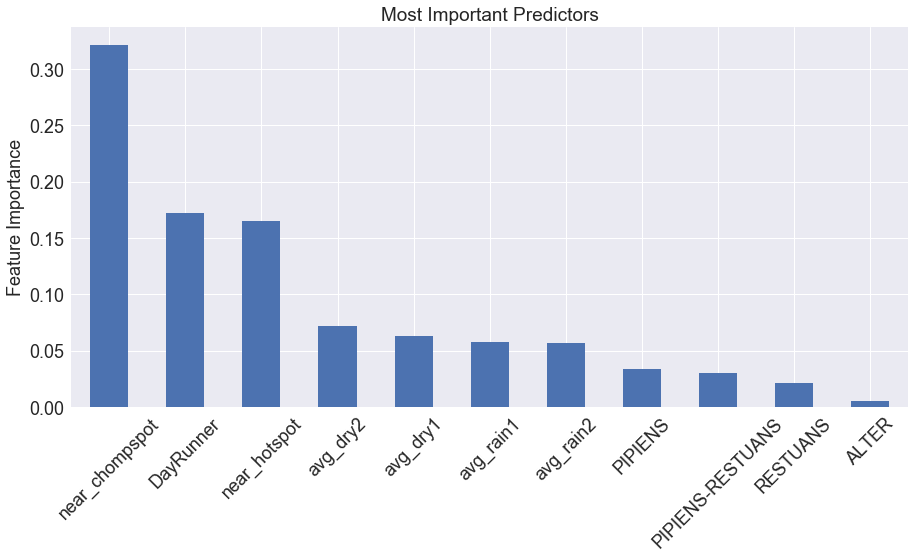

In [47]:
sns.set(style="darkgrid", color_codes=None)
# sns.palplot(sns.color_palette("RdBu", n_colors=7))
ax = top15.plot(kind='bar', legend=False, fontsize=18,  figsize=(15, 7))
plt.xticks(rotation = 45,  fontsize=18)
plt.title('Most Important Predictors',  fontsize=19)
plt.yticks(rotation = 0,  fontsize=18)
plt.ylabel('Feature Importance', rotation=90,  fontsize=18) 

# Compare Models

In [48]:
# Recap those scores for me, please.
models=['KNN', 'Logistic', 'Random Forest']
cols=['Model', 'Accuracy', 'Sensitivity', 'Specificity', 'ROC-AUC']
print(acc)
print(sens)
print(spec)
print(roc)

[94.624167459562329, 94.766888677450041, 94.243577545195052]
[3.6363636363636362, 0.0, 5.4545454545454541]
[99.648594377510037, 100.0, 99.146586345381522]
[51.642479006936838, 50.0, 52.300565899963495]


In [49]:
# Show me that in a table:
model_scores=pd.DataFrame(list(map(list, zip(models, acc, sens, spec, roc))), columns=cols)
model_scores

,Model,Accuracy,Sensitivity,Specificity,ROC-AUC
0,KNN,94.624167,3.636364,99.648594,51.642479
1,Logistic,94.766889,0.000000,100.000000,50.000000
2,Random Forest,94.243578,5.454545,99.146586,52.300566


Text(0,0.5,'Score')

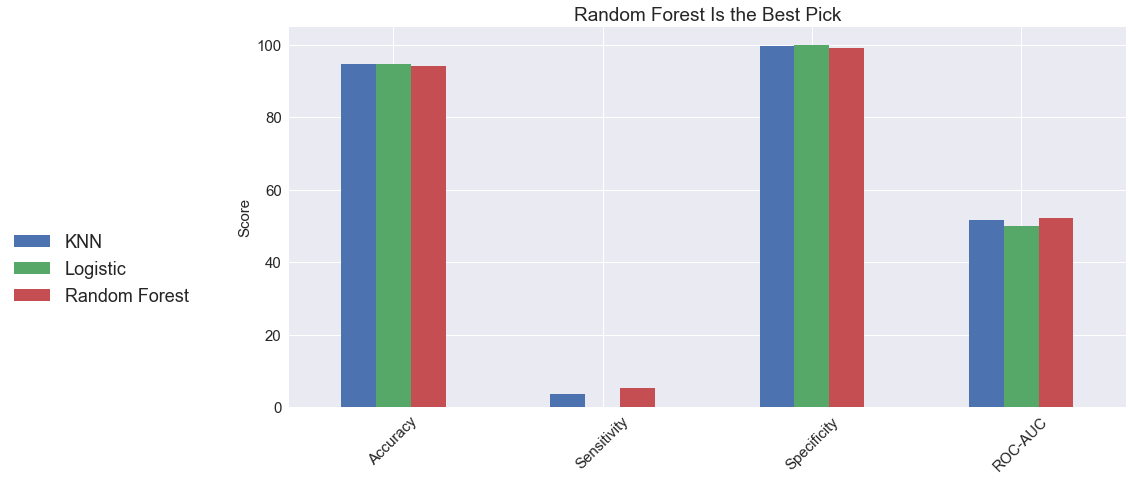

In [50]:
# Make it pretty. 
ax = model_scores.set_index('Model').T.plot(kind='bar', legend=False, fontsize=12, figsize=(15, 7))
ax.legend(loc=1, fontsize=18, bbox_to_anchor=(-0.1, 0.5))
plt.xticks(rotation = 45,  fontsize=15)
plt.title('Random Forest Is the Best Pick',  fontsize=19)
plt.yticks(rotation = 0,  fontsize=15)
plt.ylabel('Score', rotation=90,  fontsize=15)  

## Can we improve the performance of the Random Forest model with `gridsearch`?

In [51]:
from sklearn.model_selection import GridSearchCV

In [52]:
dt = RandomForestClassifier(max_features=10)
tree_model=dt.fit(X_train, y_train)

In [53]:
tree_model.get_params().keys()

dict_keys(['bootstrap', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [54]:
param_grid = {
#     'rf__n_estimators': [100,150], 
#     'rf__max_depth': [3, 4, None],
#     'rf__min_samples_split': [1, 2, 5, 10, 15, 100],
#     'rf__min_samples_leaf': [1, 2, 5, 10, 15, 100],
#     'rf__max_features': [10, 20, 25, 30],
#     'rf__class_weight': [None]    
        }

In [55]:
grid = GridSearchCV(tree_model, param_grid=param_grid, n_jobs = 1, cv=3)

In [56]:
grid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

## I'm hitting nothing but error messages on the gridsearch. Throwing in the towel (for now).